# scMeMo implementation scratch notebook

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

//anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
//anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [10]:
import sys
# sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
sys.path.append('/Users/mincheolkim/Github/scrna-parameter-estimation/scmemo')
import estimator, utils

In [11]:
# data_path = '/data/parameter_estimation/interferon_data/20200412/'
data_path = '/Users/mincheolkim/Google Drive/UCSF/research/parameter_estimation/parameter_estimation_paper/interferon_04_25_2020/'

### Perform some basic filtering

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
# adata = sc.read(data_path + 'interferon_highcount.raw.h5ad')
adata = sc.read(data_path + 'interferon.h5ad')
adata.X = adata.X.astype(np.int64)
# adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [13]:
# adata = sc.read(data_path + 'interferon.h5ad')
adata.obs['n_counts'] = adata.X.sum(axis=1)

adata.var['n_max'] = adata.X.max(axis=0).toarray()[0]
adata.var['n_cell'] = (adata.X > 0).sum(axis=0).A1



In [14]:
known_gene_df = pd.read_csv(data_path + 'chipseq/gene_locations_2.bed', header=0, sep='\t')#[[4, 5]]
known_gene_df['gene_name'] = known_gene_df['transcript'].apply(simplify_name)
known_gene_df['gene_ids'] = known_gene_df['protein'].apply(simplify_name)

In [15]:
new_var = adata.var.merge(known_gene_df, on='gene_ids', how='left')
new_var.index = adata.var.index
adata.var = new_var.copy()

In [16]:
adata.obs.cell.value_counts()

CD4 T cells          12033
CD14+ Monocytes      6447 
B cells              2880 
CD8 T cells          2634 
NK cells             2330 
FCGR3A+ Monocytes    1914 
Dendritic cells      472  
Megakaryocytes       346  
nan                  9    
Name: cell, dtype: int64

In [17]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [38]:
%%time

imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    covariate_label='stim',
    replicate_label='ind',
    batch_label=None,
    subsection_label='cell',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07,
    use_hat_matrix=True)
estimator.estimate_q_sq(verbose=True, k=5)

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x7f3e8fec7950>
Traceback (most recent call last):
  File "/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/weakref.py", line 51, in _cb
    def _cb(arg):
KeyboardInterrupt


E[q^2] falls in [0.00490, 0.00667940], with the current estimate of 0.00600778. Estimated with 6461 genes.
CPU times: user 13.7 s, sys: 1.49 s, total: 15.2 s
Wall time: 15.1 s


In [39]:
estimator.plot_cv_mean_curve()

In [40]:
gene_list = adata.var.query('n_cell > 10000').index.tolist()
print(len(gene_list))

300


In [41]:
%%time
estimator.compute_observed_moments(gene_list)

CPU times: user 1.42 s, sys: 63.8 ms, total: 1.48 s
Wall time: 1.48 s


In [42]:
%%time
estimator.estimate_1d_parameters(gene_list)

CPU times: user 481 ms, sys: 4.25 ms, total: 486 ms
Wall time: 485 ms


In [43]:
%%time
estimator.setup_hypothesis_testing(['CD4 T cells'])
estimator.compute_effect_sizes_1d(gene_list)
estimator.compute_confidence_intervals_1d(gene_list)

(300,) (300,)


/home/mkim7/Github/scrna-parameter-estimation/scmemo/scmemo.py:311: RuntimeWarning: invalid value encountered in log
  log_residual_variance = np.log(estimated_var) - (self.mean_var_slope*np.log(estimated_mean) + self.mean_var_inter)


IndexError: too many indices for array

In [37]:
%%time
estimator.compute_effect_sizes_2d(gene_list[:15], gene_list[-15:])
estimator.compute_confidence_intervals_2d(gene_list[:15], gene_list[-15:])

/home/mkim7/Github/scrna-parameter-estimation/scmemo/scmemo.py:907: RuntimeWarning: invalid value encountered in sqrt
  estimated_corrs[group] = cov / np.sqrt(estimated_vars_1[group]*estimated_vars_2[group])
/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mkim7/Github/scrna-parameter-estimation/scmemo/utils.py:99: RuntimeWarning: invalid value encountered in greater
  extreme_count = (perm_diff > 0).sum()


KeyboardInterrupt: 

In [1238]:
with open('temp.pkl', 'wb') as f:
    pkl.dump(estimator.hypothesis_test_result, f)

In [1239]:
with open('temp.pkl', 'rb') as f:
    a = pkl.load(f)

In [850]:
adata.X.sum(axis=1).A1

array([2191., 3018., 2481., ..., 1015.,  781., 1031.], dtype=float32)

In [979]:
len(estimator.groups)

133

In [1157]:
%%time
sparse_csc_array = sp.sparse.coo_matrix((30000,1), dtype=np.uint8)


CPU times: user 91 µs, sys: 21 µs, total: 112 µs
Wall time: 115 µs


In [1158]:
sparse_csc_array[:5, 0] = 5

TypeError: 'coo_matrix' object does not support item assignment

In [1145]:
%%time
sparse_lil_array = sp.sparse.lil_matrix((1, 30000), dtype=np.float64).T

CPU times: user 38.2 ms, sys: 17 µs, total: 38.2 ms
Wall time: 37.6 ms


In [1146]:
%%time
sparse_lil_array = sp.sparse.lil_matrix((30000, 1), dtype=np.float64)

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 17 ms


In [1110]:
%%time
sparse_lil_array = sp.sparse.lil_matrix((30000, 1), dtype=np.float64)
sparse_lil_array[sample_idxs, 0] = values

CPU times: user 13.4 ms, sys: 208 µs, total: 13.6 ms
Wall time: 13 ms


In [1111]:
%%time
sparse_lil_array = sp.sparse.lil_matrix((1, 30000), dtype=np.float64)
sparse_lil_array[0, sample_idxs] = values

CPU times: user 16.5 ms, sys: 108 µs, total: 16.6 ms
Wall time: 16.5 ms


In [56]:
len(1)

TypeError: object of type 'int' has no len()

In [141]:
float == np.float64

False

In [142]:
np.number

numpy.number

In [172]:
slice

slice

In [164]:
class sparse_array(object):
    """ Sparse array object. It cannot handle indexing like numpy arrays. """
    
    def __init__(self):
        
        self.values = {}
        
    def __getitem__(self, key):
        
        if np.issubdtype(type(key), np.integer):
            return self.values[key] if key in self.values else np.nan
        
        return np.array([self.values[k] if k in self.values else np.nan for k in key])
    
    def __setitem__(self, key, value):
        
        if np.issubdtype(type(key), np.integer): # any integer, meaning a single number
            self.values[key] = value
        else:
            
            if np.issubdtype(type(valuee), np.number): # any value, meaning a single number
                for k in key:
                    self.values[k] = float(value)
            else:
                for k,val in zip(key, value):
                    self.values[k] = val

In [165]:
hasattr(a, '__dict__')

True

In [166]:
a = np.random.random(10)

In [167]:
type(a[0])

numpy.float64

In [168]:
a = sparse_array()

In [171]:
a = 0:10

SyntaxError: invalid syntax (<ipython-input-171-2aeee988e1d9>, line 1)

In [169]:
a[0:10]

TypeError: 'slice' object is not iterable

In [161]:
a[5] = 100

In [162]:
a[[5, 10]]

array([100.,  nan])

In [163]:
a[10]

nan

In [124]:
a[[5, 7, 8, 9, 10]] = 10

In [125]:
sparse_csc_array = sp.sparse.csc_matrix((30000, 1), dtype=np.uint8)
dense_array = np.zeros(30000)
sparse_csr_array = sp.sparse.csr_matrix((1, 30000), dtype=np.uint8)
sparse_lil_array = sp.sparse.lil_matrix((30000, 1), dtype=np.float64)
sparse_dok_array = sp.sparse.dok_matrix((1, 30000), dtype=np.float64)
my_sparse_array = sparse_array()

In [126]:
sample_idxs = np.random.permutation(30000)[:3000]
values = np.random.choice(5, 3000)

In [127]:
%%time
my_sparse_array = sparse_array()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [128]:
%%time
sparse_csc_array = sp.sparse.csc_matrix((30000, 1), dtype=np.uint8)


CPU times: user 154 µs, sys: 1 µs, total: 155 µs
Wall time: 159 µs


In [129]:
%%time
sparse_lil_array = sp.sparse.lil_matrix((30000, 1), dtype=np.float64)


CPU times: user 67.1 ms, sys: 1.43 ms, total: 68.5 ms
Wall time: 67.7 ms


In [130]:
%%time
sparse_dok_array = sp.sparse.dok_matrix((1, 30000), dtype=np.float64)

CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 61.3 µs


In [131]:
%%time
my_sparse_array[sample_idxs] = values

CPU times: user 712 µs, sys: 60 µs, total: 772 µs
Wall time: 776 µs


In [135]:
my_sparse_array[sample_idxs]

array([4, 4, 0, ..., 4, 3, 2])

In [133]:
%%time
sparse_dok_array[0, sample_idxs] = values

CPU times: user 2.76 ms, sys: 73 µs, total: 2.83 ms
Wall time: 2.8 ms


In [101]:
%%time
sparse_csr_array[0, sample_idxs] = values

CPU times: user 1.93 ms, sys: 1.06 ms, total: 2.99 ms
Wall time: 2.01 ms


//anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [102]:
%%time
sparse_csc_array[sample_idxs, 0] = values

CPU times: user 2.08 ms, sys: 1.14 ms, total: 3.22 ms
Wall time: 2.18 ms


//anaconda3/envs/single_cell/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [103]:
%%time
dense_array[sample_idxs] = values

CPU times: user 47 µs, sys: 7 µs, total: 54 µs
Wall time: 58.2 µs


In [104]:
%%time
sparse_lil_array[sample_idxs, 0] = values

CPU times: user 1.06 ms, sys: 47 µs, total: 1.11 ms
Wall time: 1.11 ms


In [36]:
sparse_lil_array[:3, 0] = sp.sparse.lil_matrix(np.array([1, 3, 3]).reshape(-1, 1))

In [974]:
sparse_lil_array[:10, 0].todense()

matrix([[1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [955]:
values[:5]

array([3, 3, 2, 3, 3])

In [959]:
%%time
a = sparse_lil_array[sample_idxs, 0].todense().T.A1

CPU times: user 1.79 ms, sys: 0 ns, total: 1.79 ms
Wall time: 1.78 ms


In [962]:
%%time
a = sparse_lil_array[sample_idxs, 0].toarray().reshape(-1)

CPU times: user 1.55 ms, sys: 0 ns, total: 1.55 ms
Wall time: 1.54 ms


### TFKO_140 Dataset sanity check

### Qualitatively assess estimation of q_sq in the interferon data

In [622]:
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata, 
    n_umis_column='n_counts',
    num_permute=10000,
    q=.07)
estimator.compute_observed_moments(verbose=False)
estimator.estimate_q_sq(frac=1)
estimator.estimate_1d_parameters()

observed_content = adata.obs['n_counts']
q_sq_upper_lim = (observed_content**2).mean()/observed_content.mean()**2*estimator.q**2
q_sq_lower_lim = estimator.q**2
print('estimated', estimator.q_sq)
print('upper limit', q_sq_upper_lim)
print('lower limit', q_sq_lower_lim)

x_obs = np.log(estimator.observed_central_moments['all']['first'])
y_obs = np.log(estimator.observed_central_moments['all']['second'])

x_est = np.log(estimator.estimated_central_moments['all']['first'])
y_est = np.log(estimator.estimated_central_moments['all']['second'])

E[q^2] falls in [0.00490, 0.00667941], with the current estimate of 0.00600778
estimated 0.00600778353214264
upper limit 0.00667940500948918
lower limit 0.004900000000000001


Text(0, 0.5, 'log( estimated cv )')

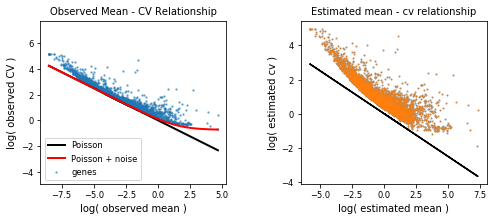

In [623]:
plt.figure(figsize=(8, 3));
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1)
estimator.plot_cv_mean_curve('all', estimated=False, plot_noise=True)
plt.subplot(1, 2, 2)
plt.scatter(x_est, y_est/2-x_est, s=1, alpha=0.5)
plt.scatter(x_est[estimator.k_largest_indices], y_est[estimator.k_largest_indices]/2-x_est[estimator.k_largest_indices], s=1, alpha=0.5)
plt.plot(x_est, -x_est/2, color='k')
plt.title('Estimated mean - cv relationship')
plt.xlabel('log( estimated mean )')
plt.ylabel('log( estimated cv )')

### Assess the correlation between two genes as a function of the expectation. 

Ideally, there shouldn't be any relationship between these two things. Correlation should be an orthogonal measurement.

corr (0.6220398921276906, 0.0)
overall corr mean 0.10659034


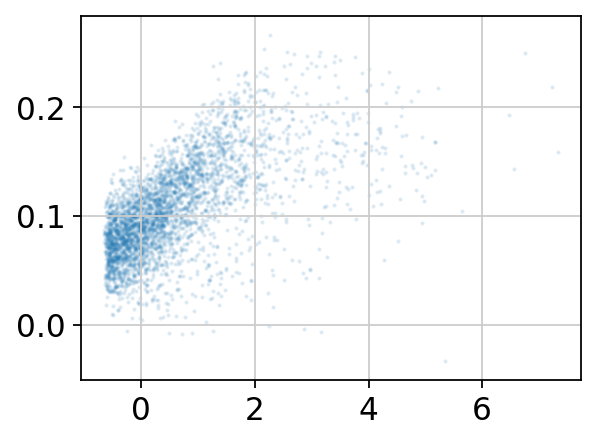

In [582]:
# minimal q_sq
means = estimator.parameters['all']['log_mean']
corr_means = np.nanmean(estimator.parameters['all']['corr'].toarray(), axis=0)
plt.scatter(means, corr_means, s=1, alpha=0.1)
print('corr', utils.robust_corr(means[means<2], corr_means[means<2]))
print('overall corr mean', np.nanmean(estimator.parameters['all']['corr'].toarray()))

corr (-0.13309966872329132, 1.4572298007932834e-14)
overall corr mean -0.032476626


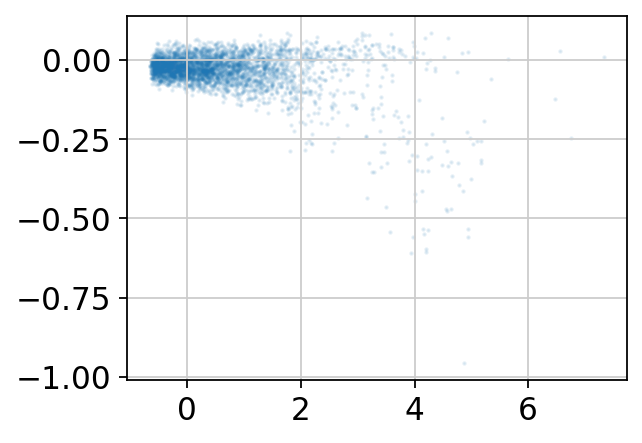

In [580]:
# actual q_sq
means = estimator.parameters['all']['log_mean']
corr_means = np.nanmean(estimator.parameters['all']['corr'].toarray(), axis=0)
plt.scatter(means, corr_means, s=1, alpha=0.1)
print('corr', utils.robust_corr(means[means<2], corr_means[means<2]))
print('overall corr mean', np.nanmean(estimator.parameters['all']['corr'].toarray()))

### Correlation dependency on the mean

In [208]:
adata.obs['course_cell_type'] = 'PBMC'

In [209]:
imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    n_umis_column='n_counts',
    covariate_label='stim',
    replicate_label=None,
    batch_label=None,
    subsection_label='course_cell_type',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07)
estimator.compute_observed_moments(verbose=False)
estimator.estimate_q_sq(frac=0.3)

E[q^2] falls in [0.00490, 0.00656014], with the current estimate of 0.00583674


In [210]:
sample_idxs = np.random.choice(adata.var.shape[0], 500)
sample_genes = adata.var.index[sample_idxs].tolist()

In [211]:
estimator.estimate_1d_parameters()
estimator.estimate_2d_parameters(sample_genes, sample_genes)


In [167]:
means = []
median_corrs = []
for group in estimator.groups:
    means.append(estimator.parameters[group]['log_mean'][sample_idxs])
    median_corrs.append(np.nanmean(estimator.parameters[group]['corr'][sample_idxs, :][:, sample_idxs].toarray(), axis=0))
means = np.concatenate(means)
median_corrs = np.concatenate(median_corrs)

### Sanity check known correlations

In [212]:
highcount_genes = adata.var.copy()
highcount_genes['gene'] = highcount_genes.index.tolist()

In [213]:
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['gene_name', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(highcount_genes[['gene_name', 'gene_ids', 'gene']], on='gene_name', how='inner')
isgf3_genes = isgf3_df['gene'].drop_duplicates().tolist()

In [215]:
imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    n_umis_column='n_counts',
    covariate_label='stim',
    replicate_label='ind',
    batch_label=None,
    subsection_label='course_cell_type',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07)
estimator.compute_observed_moments(verbose=False)
estimator.estimate_q_sq(frac=0.3)

E[q^2] falls in [0.00490, 0.00656014], with the current estimate of 0.00583674


In [216]:
gene_list_1, gene_list_2 = [ 'STAT1', 'STAT2'], isgf3_genes
gene_idxs_1, gene_idxs_2 = estimator._get_gene_idxs(gene_list_1), estimator._get_gene_idxs(gene_list_2)

In [217]:
estimator.setup_hypothesis_testing(['PBMC'])

In [218]:
%%time
estimator.estimate_1d_parameters()
estimator.compute_effect_sizes_1d()
# estimator.compute_confidence_intervals_1d()

CPU times: user 71.9 ms, sys: 2.03 ms, total: 74 ms
Wall time: 65.6 ms


In [219]:
estimator.estimate_2d_parameters(gene_list_1, gene_list_2)
estimator.compute_effect_sizes_2d(gene_list_1, gene_list_2)

In [220]:
%%time
estimator.compute_confidence_intervals_2d(gene_list_1, gene_list_2)

CPU times: user 3min 56s, sys: 23.3 s, total: 4min 20s
Wall time: 2min 5s


In [230]:
estimator.hypothesis_test_result['PBMC']['dc_effect_size'][gene_idxs_1, :][:, gene_idxs_2].todense()[0, :].A1.mean()

0.04218902

In [241]:
stat1_effect_size = \
    estimator.hypothesis_test_result['PBMC']['dc_effect_size'][gene_idxs_1, :][:, gene_idxs_2]\
    .todense()[0, :].A1
stat2_effect_size = \
    estimator.hypothesis_test_result['PBMC']['dc_effect_size'][gene_idxs_1, :][:, gene_idxs_2]\
    .todense()[1, :].A1
stat1_pvals = \
    estimator.hypothesis_test_result['PBMC']['dc_pval'][gene_idxs_1, :][:, gene_idxs_2]\
    .todense()[0, :].A1
stat2_pvals = \
    estimator.hypothesis_test_result['PBMC']['dc_pval'][gene_idxs_1, :][:, gene_idxs_2]\
    .todense()[1, :].A1

In [478]:
stat1_effect_size

array([ 1.66702673e-01,  7.14170933e-03,  1.58807471e-01,  3.87321413e-02,
        7.78314248e-02,  5.97702079e-02, -6.86575323e-02,  3.37967351e-02,
        1.35393947e-01,  3.37775908e-02,  9.22059491e-02, -7.84675777e-02,
        1.53891712e-01,  1.72906771e-01,  1.68017477e-01,  1.20765381e-01,
        4.44723619e-03, -3.83245386e-02, -2.41982535e-01,  2.84156785e-03,
        1.08625414e-03,  3.44101153e-02, -5.19023836e-02,  6.91946894e-02,
       -4.61255349e-02, -2.51306803e-04,  4.44837622e-02,  2.08861619e-01,
        2.19246373e-01,  9.61949229e-02, -3.10540833e-02,  9.63045936e-03,
        1.57404527e-01, -1.37050614e-01, -1.13524254e-02,  8.58241171e-02,
        8.00931007e-02,  6.29005358e-02, -1.53882772e-01,  2.09638938e-01,
        1.48946671e-02, -5.61694279e-02,  3.37284878e-02,  4.51222062e-02,
        7.53353462e-02, -9.18429531e-03,  6.09506853e-02,  2.98828464e-02,
        1.81093812e-01,  2.52153706e-02,  2.07966819e-01,  2.20514163e-01,
        1.25338696e-02,  

In [479]:
stat2_effect_size

array([ 2.75495023e-01,  2.84356773e-01,  3.42401117e-01,  1.89631194e-01,
        7.79870898e-02,  1.66966356e-02,  1.40642703e-01, -9.57057402e-02,
        1.53120086e-01,  1.08517982e-01,  2.99992561e-01, -3.36988233e-02,
        1.64594859e-01,  2.44968861e-01,  2.84728408e-02,  3.30180734e-01,
        1.97286665e-01,  1.87503681e-01, -9.34909731e-02,  1.23034053e-01,
       -1.21245831e-02, -7.64667690e-02, -1.32986084e-01,  1.97814867e-01,
       -3.71283763e-16,  2.50941843e-01,  1.93425074e-01,  2.39820361e-01,
        2.53113031e-01,  1.63341522e-01,  1.16606057e-01,  6.41604364e-02,
        2.46400684e-01, -3.20894092e-01,  1.77702010e-01,  1.02175578e-01,
        1.10782824e-01,  2.23035753e-01,  1.45433605e-01,  1.14294119e-01,
        2.16457009e-01,  2.25251362e-01, -6.02170527e-02,  2.41353422e-01,
       -1.59425717e-02,  7.94149488e-02,  2.76277047e-02,  6.40885532e-02,
        1.99207693e-01,  5.76160140e-02,  1.68874323e-01,  2.27922291e-01,
        1.04983866e-01,  

In [242]:
((stat1_effect_size > 0) & (stat1_pvals < 0.05)).sum()

20

In [243]:
((stat2_effect_size > 0) & (stat2_pvals < 0.05)).sum()

40

In [238]:
(stat1_pvals < 0.05).sum()

28

In [240]:
(stat2_pvals < 0.05).sum()

43

In [237]:
len(isgf3_genes)

112

In [ ]:
stat1_pv

### Implementation scratch

In [363]:
X = adata.X[:, 0:1000].copy()

In [364]:
Y = adata.X[:, 15:1000].copy()

In [381]:
def _compute_1d_statistics(observed, N, smooth=True):
	""" Compute some non central moments of the observed data. """

	pseudocount = 1/observed.shape[1] if smooth else 0

	if type(observed) != np.ndarray:

		# count unique values in each column
		#unique_counts = pd.DataFrame(observed.toarray()).nunique().values

		first = (observed.sum(axis=0).A1 + pseudocount)/(observed.shape[0]+pseudocount*observed.shape[1])
		c = observed.copy()
		c.data **= 2
		second = (c.sum(axis=0).A1 + pseudocount)/(observed.shape[0]+pseudocount*observed.shape[1])
		del c

	else:

		#unique_counts = pd.DataFrame(observed).nunique().values
		first = (observed.sum(axis=0) + pseudocount)/(observed.shape[0]+pseudocount*observed.shape[1])
		second = ((observed**2).sum(axis=0) + pseudocount)/(observed.shape[0]+pseudocount*observed.shape[1])

	# Return the first moment, second moment, expectation of the product
	# Make some columns into NaN
	#econd[unique_counts <= 2] = np.nan
	return first, second

In [378]:
row_mat = adata.X
col_mat = adata.X.tocsc()

In [379]:
%%time
temp1 = row_mat[:, [3, 5, 3, 1, 3, 4]]

CPU times: user 24.3 ms, sys: 66 µs, total: 24.3 ms
Wall time: 23.7 ms


In [380]:
%%time
temp1 = col_mat[:, [3, 5, 3, 1, 3, 4]]

CPU times: user 634 µs, sys: 175 µs, total: 809 µs
Wall time: 525 µs


In [395]:
%%time
temp1 = row_mat[[3, 5, 3, 1, 3, 4, 5, 6, 7, 8, 9], :]

CPU times: user 644 µs, sys: 178 µs, total: 822 µs
Wall time: 564 µs


In [394]:
%%time
temp1 = col_mat[[3, 5, 3, 1, 3, 4, 5, 6, 7, 8, 9], :]

CPU times: user 24.7 ms, sys: 0 ns, total: 24.7 ms
Wall time: 23.9 ms


In [391]:
%%time
row_mat.sum(axis=0)

CPU times: user 13.5 ms, sys: 3.32 ms, total: 16.9 ms
Wall time: 15.9 ms


matrix([[2.10400e+03, 5.88100e+03, 5.74972e+05, ..., 1.66000e+02,
         3.25000e+02, 6.94200e+03]], dtype=float32)

In [393]:
%%time
adata.X.tocsc()

CPU times: user 149 ms, sys: 36.3 ms, total: 185 ms
Wall time: 184 ms


<29065x5696 sparse matrix of type '<class 'numpy.float32'>'
	with 15546935 stored elements in Compressed Sparse Column format>

In [392]:
%%time
col_mat.sum(axis=0)

CPU times: user 6.58 ms, sys: 0 ns, total: 6.58 ms
Wall time: 5.86 ms


matrix([[2.10400e+03, 5.88100e+03, 5.74972e+05, ..., 1.66000e+02,
         3.25000e+02, 6.94200e+03]], dtype=float32)

In [423]:
adata.X = adata.X.astype(np.int32).tocsc()

In [424]:
def sparse_bincount(col):
    
    counts = np.bincount(col.data)
    counts[0] = col.shape[0] - col.data.shape[0]
    return counts

In [427]:
%%time
a = np.unique(adata.X[:, 2].toarray().reshape(-1))

CPU times: user 1.79 ms, sys: 494 µs, total: 2.28 ms
Wall time: 1.65 ms


In [426]:
%%time
b = sparse_bincount(adata.X[:, 2])

CPU times: user 812 µs, sys: 0 ns, total: 812 µs
Wall time: 537 µs


In [469]:
def pair(k1, k2, safe=True):
    """
    Cantor pairing function
    http://en.wikipedia.org/wiki/Pairing_function#Cantor_pairing_function
    """
    z = (0.5 * (k1 + k2) * (k1 + k2 + 1) + k2)#.astype(int)
    return z


def depair(z):
    """
    Inverse of Cantor pairing function
    http://en.wikipedia.org/wiki/Pairing_function#Inverting_the_Cantor_pairing_function
    """
    w = np.floor((np.sqrt(8 * z + 1) - 1)/2)
    t = (w**2 + w) / 2
    y = (z - t).astype(int)
    x = (w - y).astype(int)
    return x, y

In [471]:
col_1 = adata.X[:, 2]
col_2 = adata.X[:, 1]

In [472]:
%%time
a = pair(col_1.todense().A1, col_2.todense().A1)

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.47 ms


In [473]:
a

array([ 0.,  0.,  0., ..., 10., 36.,  6.])

In [468]:
%%time
a = pair(col_1, col_2)

NotImplementedError: adding a nonzero scalar to a sparse matrix is not supported

### Scratch

In [476]:
(adata.var['n_max'] > 50).values

array([False, False,  True, ..., False, False, False])

In [477]:
adata_test = adata[:, (adata.var['n_max'] > 50).values].copy()

AnnData object with n_obs × n_vars = 29065 × 118 
    obs: 'tsne1', 'tsne2', 'ind', 'stim', 'cluster', 'cell', 'multiplets', 'n_counts', 'cell_type'
    var: 'gene_ids', 'n_max', 'n_cell', '#chrom', 'chromStart', 'chromEnd', 'clusterId', 'transcript', 'protein', 'gene_name', 'idx'
    uns: 'cell_type_colors'
    obsm: 'X_tsne'


In [485]:
adata_test.obs['coarse_cell_type'] = 'PBMC'

In [601]:
imp.reload(utils)
imp.reload(scmemo)
estimator = scmemo.SingleCellEstimator(
    adata=adata,
    n_umis_column='n_counts',
    covariate_label='stim',
    replicate_label='ind',
    batch_label=None,
    subsection_label='cell',
    num_permute=10000,
    covariate_converter={'ctrl':0, 'stim':1},
    q=.07,
    use_hat_matrix=True)
estimator.compute_observed_moments(verbose=False)
estimator.q_sq = 0.00583674
# estimator.estimate_q_sq(frac=0.3)

In [602]:
estimator.setup_hypothesis_testing(['CD14+ Monocytes'])

In [603]:
%%time
estimator.estimate_1d_parameters()
estimator.compute_effect_sizes_1d()
# estimator.compute_confidence_intervals_1d(verbose=True)

CPU times: user 2.61 s, sys: 131 ms, total: 2.74 s
Wall time: 2.74 s


In [604]:
gene_list_1, gene_list_2 = ['ISG15', 'LTB'], ['IFIT1', 'IFIT2', 'ISG15', 'OAS1', 'OAS2', 'OASL']

In [605]:
estimator.estimate_2d_parameters(gene_list_1, gene_list_2)
estimator.compute_effect_sizes_2d(gene_list_1, gene_list_2)

In [606]:
%%time
# estimator.compute_confidence_intervals_2d(gene_list_1, gene_list_2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [607]:
gene_idxs_1, gene_idxs_2 = estimator._get_gene_idxs(gene_list_1), estimator._get_gene_idxs(gene_list_2)

In [608]:
print(
    estimator.hypothesis_test_result['CD14+ Monocytes']['de_effect_size'][gene_idxs_2])

[5.42967048 5.49296826 4.89392576 3.1844887  3.30849258 2.74299873]


In [609]:
print(
    estimator.hypothesis_test_result['CD14+ Monocytes']['dv_effect_size'][gene_idxs_2])

[ 0.92030634  1.70648132 -0.16083942 -0.03448538 -0.46953529 -0.64907324]


(-3, 3)

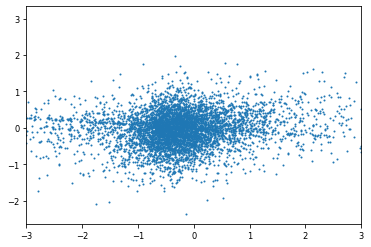

In [610]:
plt.scatter(
    estimator.hypothesis_test_result['CD14+ Monocytes']['de_effect_size'],
    estimator.hypothesis_test_result['CD14+ Monocytes']['dv_effect_size'],
    s=1
)
plt.xlim(-3, 3)

In [591]:
estimator.parameters['sg^ctrl^default_rep^default_batch^CD14+ Monocytes']['log_residual_var'][gene_idxs_2]

array([2.39485627, 1.39611813, 3.67372015, 1.59502471, 0.13028864,
       1.57760438])

In [592]:
estimator.parameters['sg^stim^default_rep^default_batch^CD14+ Monocytes']['log_residual_var'][gene_idxs_2]

array([ 1.98669526,  2.04328389,  2.85462704,  1.07961847, -0.36843998,
        0.59611142])

In [593]:
estimator.hypothesis_test_result['CD14+ Monocytes']['design_df']

,covariate,replicate,batch,constant,cell_count
0,0,default_rep,default_batch,1,3365
1,1,default_rep,default_batch,1,3082


In [594]:
print(
    estimator.hypothesis_test_result['CD14+ Monocytes']['de_effect_size'][gene_idxs_2])

[5.14739925 5.13568147 4.63307321 3.00384854 3.102129   2.71677435]


In [596]:
print(
    estimator.hypothesis_test_result['CD14+ Monocytes']['dv_effect_size'][gene_idxs_2])

[-0.408161    0.64716576 -0.81909311 -0.51540624 -0.49872862 -0.98149296]


(-3, 3)

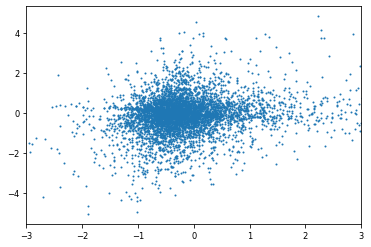

In [598]:
plt.scatter(
    estimator.hypothesis_test_result['CD14+ Monocytes']['de_effect_size'],
    estimator.hypothesis_test_result['CD14+ Monocytes']['dv_effect_size'],
    s=1
)
plt.xlim(-3, 3)

In [599]:
utils.robust_corr(    estimator.hypothesis_test_result['CD14+ Monocytes']['de_effect_size'],
    estimator.hypothesis_test_result['CD14+ Monocytes']['dv_effect_size'],)

(0.11004648596928213, 8.160027454307092e-17)